In [60]:
import seaborn as sns
import pandas as pd
import wandb
from matplotlib import pyplot as plt
import numpy as np

In [44]:
# Functions

def load_sweeps(sweeps, config_save, max_samples_per_run):
    filter_dict = {"sweep":{"$in":sweeps}}
    api = wandb.Api(timeout=30)
    entity, project = "ltecot", "quantum_optimization"
    runs = api.runs(entity + "/" + project, filters=filter_dict)
    summary_list, config_list, name_list = [], [], []
    runs_list = []
    for run in runs:
        run_data = run.history(samples=max_samples_per_run)
        remove_columns = [k for k in run_data.columns.values if k.startswith('_')]
        run_data = run_data.drop(columns=remove_columns)
        save_from_config = dict((k, run.config[k]) for k in config_save)
        save_from_config["run_name"] = run.name
        run_data = run_data.assign(**save_from_config)
        runs_list.append(run_data)
        print("Loaded " + run.name)
    runs_df = pd.concat(runs_list)
    return runs_df

# Filter for rows that are the final step of each run
def get_final_values(df):
    last_step = df['step'].max()
    return df.loc[df['step'] == last_step]

In [70]:
# Load experiment runs
# Don't worry if this hangs, it can take a very long time
# Loading too many might overload your machine, so be careful when doing so

max_samples_per_run = 5000
config_save = ["optimizer", "rand_seed"]
# Run Processing
# Stuff like changing optimizer names to be prettier
replace_dict = {"adamspsa" : "adamSPSA",
                "pl_qnspsa" : "QNSPSA",
                "qnspsa" : "QNSPSA",
                "2spsa" : "2-SPSA",
                "xnes" : "xNES",
                "snes" : "sNES",
                "spsa" : "SPSA",
                "ges" : "GES",
               }
# So we can have consistent colors per optimizer : 
optimizer_palette ={'SPSA':'#4c72b0',
                    'adamSPSA':'#dd8452',
                    'QNSPSA':'#55a868',
                    '2-SPSA':'#c44e52',
                    'xNES':'#8172b3',
                    'sNES':'#937860',
                    'GES':'#da8bc3',}
# To set order of plotting in boxplot / legend in convergence plots
optimizer_order = ['SPSA','adamSPSA','QNSPSA','2-SPSA','xNES','sNES','GES']

# -----------------------------------------------------------

ising_1d_sweeps = ["ynq6zj7a","grtaezvx","osdq0v2h","8le1ihts","v3zzxoqv","b07fcmu0","6f90a439"]
ising_1d_runs = load_sweeps(ising_1d_sweeps, config_save, max_samples_per_run)
ising_1d_runs = ising_1d_runs.replace(replace_dict)

random_ham_sweeps = ["8b8lwlv8","22xzl1bd","dzvcaan7","ho3hfydo","hcsc8mab","8nbjvao2","wmmtqzko"]
random_ham_runs = load_sweeps(random_ham_sweeps, config_save, max_samples_per_run)
random_ham_runs = random_ham_runs.replace(replace_dict)

heisenburg_2d_sweeps = ["3eopljqi","p2a0wxah","k705w87h","s1jicn6x","dmlpp14c","6tcfsh92","ftlb19yf"]
heisenburg_2d_runs = load_sweeps(heisenburg_2d_sweeps, config_save, max_samples_per_run)
heisenburg_2d_runs = heisenburg_2d_runs.replace(replace_dict)

# qcbm_gen_sweeps = ["bjennlze","s6idzkbv","2j1p202e","bu34865l","leqxvsni","k8mltsz3","dabbmnw8"]
# qcbm_gen_runs = load_sweeps(qcbm_gen_sweeps, config_save, max_samples_per_run)
# qcbm_gen_runs = qcbm_gen_runs.replace(replace_dict)

# rand_gen_sweeps = ["84e9cuqw", "a2slzesk", "wng8b0qb", "25dqhywx", "myazxi2c", "hsyrrsew", "s8rk9zse"]
# rand_gen_runs = load_sweeps(rand_gen_sweeps, config_save, max_samples_per_run)
# rand_gen_runs = rand_gen_runs.replace(replace_dict)


Loaded laced-sweep-100
Loaded legendary-sweep-99
Loaded lemon-sweep-98
Loaded volcanic-sweep-97
Loaded expert-sweep-96
Loaded snowy-sweep-95
Loaded swift-sweep-94
Loaded fast-sweep-93
Loaded distinctive-sweep-92
Loaded snowy-sweep-91
Loaded dazzling-sweep-90
Loaded earthy-sweep-89
Loaded electric-sweep-88
Loaded curious-sweep-87
Loaded true-sweep-86
Loaded deep-sweep-85
Loaded summer-sweep-84
Loaded faithful-sweep-83
Loaded laced-sweep-82
Loaded toasty-sweep-81
Loaded dandy-sweep-80
Loaded comfy-sweep-79
Loaded genial-sweep-78
Loaded robust-sweep-77
Loaded silver-sweep-76
Loaded snowy-sweep-75
Loaded peachy-sweep-74
Loaded restful-sweep-73
Loaded graceful-sweep-72
Loaded fanciful-sweep-71
Loaded young-sweep-70
Loaded autumn-sweep-69
Loaded expert-sweep-68
Loaded pleasant-sweep-67
Loaded kind-sweep-66
Loaded logical-sweep-65
Loaded lively-sweep-64
Loaded wandering-sweep-63
Loaded wild-sweep-62
Loaded eternal-sweep-61
Loaded quiet-sweep-60
Loaded astral-sweep-59
Loaded kind-sweep-58
Load

Loaded fast-sweep-71
Loaded drawn-sweep-75
Loaded mild-sweep-73
Loaded trim-sweep-74
Loaded wise-sweep-70
Loaded pleasant-sweep-26
Loaded sage-sweep-72
Loaded decent-sweep-73
Loaded dashing-sweep-69
Loaded treasured-sweep-71
Loaded radiant-sweep-72
Loaded comfy-sweep-68
Loaded absurd-sweep-70
Loaded daily-sweep-71
Loaded wandering-sweep-25
Loaded solar-sweep-67
Loaded unique-sweep-69
Loaded silver-sweep-70
Loaded vital-sweep-66
Loaded fragrant-sweep-68
Loaded ancient-sweep-69
Loaded avid-sweep-65
Loaded super-sweep-67
Loaded crisp-sweep-68
Loaded ethereal-sweep-64
Loaded gentle-sweep-24
Loaded cosmic-sweep-66
Loaded swept-sweep-67
Loaded fallen-sweep-63
Loaded magic-sweep-65
Loaded fast-sweep-66
Loaded whole-sweep-62
Loaded jumping-sweep-64
Loaded dashing-sweep-65
Loaded stilted-sweep-61
Loaded youthful-sweep-23
Loaded bright-sweep-64
Loaded avid-sweep-63
Loaded sunny-sweep-60
Loaded magic-sweep-63
Loaded olive-sweep-62
Loaded hopeful-sweep-59
Loaded quiet-sweep-61
Loaded generous-swee

Loaded copper-sweep-88
Loaded valiant-sweep-87
Loaded fresh-sweep-86
Loaded rose-sweep-85
Loaded fancy-sweep-84
Loaded charmed-sweep-83
Loaded noble-sweep-82
Loaded hopeful-sweep-81
Loaded lilac-sweep-80
Loaded quiet-sweep-79
Loaded light-sweep-78
Loaded vocal-sweep-77
Loaded silver-sweep-76
Loaded dark-sweep-75
Loaded crimson-sweep-74
Loaded chocolate-sweep-73
Loaded stoic-sweep-72
Loaded hearty-sweep-71
Loaded crisp-sweep-70
Loaded eternal-sweep-69
Loaded eager-sweep-68
Loaded graceful-sweep-67
Loaded gallant-sweep-66
Loaded dark-sweep-65
Loaded volcanic-sweep-64
Loaded brisk-sweep-63
Loaded amber-sweep-62
Loaded royal-sweep-61
Loaded sweet-sweep-60
Loaded playful-sweep-59
Loaded fine-sweep-58
Loaded avid-sweep-57
Loaded radiant-sweep-56
Loaded royal-sweep-55
Loaded happy-sweep-54
Loaded valiant-sweep-53
Loaded drawn-sweep-52
Loaded visionary-sweep-51
Loaded bright-sweep-50
Loaded royal-sweep-49
Loaded scarlet-sweep-48
Loaded cerulean-sweep-47
Loaded olive-sweep-46
Loaded treasured-s

Loaded dulcet-sweep-61
Loaded distinctive-sweep-54
Loaded hardy-sweep-37
Loaded misty-sweep-79
Loaded astral-sweep-60
Loaded winter-sweep-53
Loaded radiant-sweep-36
Loaded serene-sweep-59
Loaded swept-sweep-52
Loaded confused-sweep-78
Loaded spring-sweep-35
Loaded bumbling-sweep-58
Loaded unique-sweep-51
Loaded dulcet-sweep-34
Loaded worthy-sweep-77
Loaded sparkling-sweep-57
Loaded treasured-sweep-50
Loaded dazzling-sweep-33
Loaded polar-sweep-56
Loaded electric-sweep-76
Loaded likely-sweep-49
Loaded jumping-sweep-32
Loaded light-sweep-55
Loaded lemon-sweep-48
Loaded leafy-sweep-75
Loaded super-sweep-31
Loaded clean-sweep-54
Loaded firm-sweep-47
Loaded azure-sweep-53
Loaded rare-sweep-30
Loaded crimson-sweep-74
Loaded deep-sweep-46
Loaded easy-sweep-52
Loaded generous-sweep-29
Loaded prime-sweep-73
Loaded worldly-sweep-45
Loaded silvery-sweep-51
Loaded soft-sweep-28
Loaded electric-sweep-44
Loaded autumn-sweep-72
Loaded charmed-sweep-50
Loaded twilight-sweep-27
Loaded light-sweep-43
Lo

Loaded pious-sweep-75
Loaded sweet-sweep-74
Loaded happy-sweep-73
Loaded grateful-sweep-72
Loaded summer-sweep-71
Loaded restful-sweep-70
Loaded divine-sweep-69
Loaded vocal-sweep-68
Loaded magic-sweep-67
Loaded toasty-sweep-66
Loaded soft-sweep-65
Loaded firm-sweep-64
Loaded hopeful-sweep-63
Loaded expert-sweep-62
Loaded twilight-sweep-61
Loaded pretty-sweep-60
Loaded glorious-sweep-59
Loaded sage-sweep-58
Loaded icy-sweep-57
Loaded radiant-sweep-56
Loaded fine-sweep-55
Loaded quiet-sweep-54
Loaded solar-sweep-53
Loaded silvery-sweep-52
Loaded helpful-sweep-51
Loaded unique-sweep-50
Loaded trim-sweep-49
Loaded dazzling-sweep-48
Loaded leafy-sweep-47
Loaded spring-sweep-46
Loaded frosty-sweep-45
Loaded lucky-sweep-44
Loaded giddy-sweep-43
Loaded classic-sweep-42
Loaded logical-sweep-41
Loaded legendary-sweep-40
Loaded charmed-sweep-39
Loaded gentle-sweep-38
Loaded lilac-sweep-37
Loaded magic-sweep-36
Loaded helpful-sweep-35
Loaded fresh-sweep-34
Loaded balmy-sweep-33
Loaded feasible-sw

Loaded expert-sweep-74
Loaded gallant-sweep-80
Loaded super-sweep-54
Loaded serene-sweep-71
Loaded stilted-sweep-79
Loaded tough-sweep-73
Loaded ruby-sweep-4
Loaded divine-sweep-53
Loaded trim-sweep-70
Loaded radiant-sweep-36
Loaded lemon-sweep-78
Loaded warm-sweep-72
Loaded icy-sweep-69
Loaded ethereal-sweep-52
Loaded colorful-sweep-77
Loaded sweet-sweep-71
Loaded classic-sweep-68
Loaded eternal-sweep-35
Loaded deep-sweep-76
Loaded kind-sweep-70
Loaded dry-sweep-51
Loaded wise-sweep-67
Loaded polar-sweep-75
Loaded major-sweep-69
Loaded happy-sweep-50
Loaded vivid-sweep-74
Loaded dandy-sweep-66
Loaded fanciful-sweep-34
Loaded brisk-sweep-68
Loaded cool-sweep-73
Loaded sunny-sweep-65
Loaded spring-sweep-49
Loaded different-sweep-67
Loaded amber-sweep-72
Loaded restful-sweep-33
Loaded sunny-sweep-64
Loaded divine-sweep-66
Loaded vocal-sweep-48
Loaded drawn-sweep-71
Loaded ethereal-sweep-63
Loaded ethereal-sweep-65
Loaded comic-sweep-70
Loaded zany-sweep-47
Loaded jumping-sweep-32
Loaded 

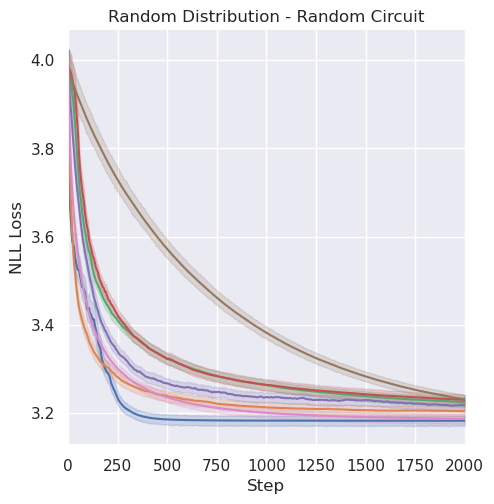

In [76]:
# Convergence plots

# ----- Input Properties -----

# curr_data, x_data, x_lim, x_label, y_label, title = ising_1d_runs, "step", 500, "Step", "Energy", "1D Ising"
# curr_data, x_data, x_lim, x_label, y_label, title = ising_1d_runs, "num_shots", 1000, "Circuit Evaluations", "Energy", "1D Ising"
# curr_data, x_data, x_lim, x_label, y_label, title = random_ham_runs, "step", 500, "Step", "Energy", "Randomized Hamiltonian"
# curr_data, x_data, x_lim, x_label, y_label, title = random_ham_runs, "num_shots", 1000, "Circuit Evaluations", "Energy", "Randomized Hamiltonian"
# curr_data, x_data, x_lim, x_label, y_label, title = heisenburg_2d_runs, "step", 2000, "Step", "Energy", "2D Heisenburg"
# curr_data, x_data, x_lim, x_label, y_label, title = heisenburg_2d_runs, "num_shots", 4000, "Circuit Evaluations", "Energy", "2D Heisenburg"
# curr_data, x_data, x_lim, x_label, y_label, title = qcbm_gen_runs, "step", 5000, "Step", "NLL Loss", "Cardinality Distribution - QCBM"
# curr_data, x_data, x_lim, x_label, y_label, title = qcbm_gen_runs, "num_shots", 10000, "Circuit Evaluations", "NLL Loss", "Cardinality Distribution - QCBM"
curr_data, x_data, x_lim, x_label, y_label, title = rand_gen_runs, "step", 2000, "Step", "NLL Loss", "Random Distribution - Random Circuit"
# curr_data, x_data, x_lim, x_label, y_label, title = rand_gen_runs, "num_shots", 5000, "Circuit Evaluations", "NLL Loss", "Random Distribution - Random Circuit"

# remove_legend = False
remove_legend = True

# Filter, for sub-sampling the data if seaborn can't handle it all
# step_filter_freq = 1
step_filter_freq = 5
# step_filter_freq = 100

context = "notebook" # “notebook”, “paper”, “talk”, “poster”

# ----------------------------

sns.set_theme()
sns.set_context(context)

# ax = sns.relplot(data=curr_data, x="step", y="loss", hue="optimizer", kind="line", errorbar="sd")
# ax = sns.relplot(data=curr_data, x="step", y="loss", hue="optimizer", kind="line", errorbar=None)

filter_inds = ((curr_data["step"] % step_filter_freq == 0) & (curr_data[x_data] <= x_lim)) | (curr_data[x_data] == x_lim-1)
curr_data = curr_data[filter_inds]
ax = sns.relplot(data=curr_data, x=x_data, y="loss", hue="optimizer", kind="line", palette=optimizer_palette, hue_order=optimizer_order)
ax.set(xlim=(0,x_lim), xlabel=x_label, ylabel=y_label, title=title)
if remove_legend:
    ax._legend.remove()
else:
    plt.legend(loc="upper left", ncol=7)
#     ax._legend.set_title("Optimzer")
#     sns.move_legend(ax, "upper right")

      num_shots      loss  step optimizer  rand_seed            run_name
4999      34993  3.243810  4999    QNSPSA       6133      fast-sweep-100
4999      34993  3.230184  4999    QNSPSA       9708  resilient-sweep-99
4999      34993  3.262013  4999    QNSPSA       6625    classic-sweep-98
4999      34993  3.121084  4999    QNSPSA       7125   colorful-sweep-97
4999      34993  3.225393  4999    QNSPSA       3541       warm-sweep-96
...         ...       ...   ...       ...        ...                 ...
4999       9998  3.120284  4999      xNES       5632       happy-sweep-1
4999      34993  3.133704  4999    QNSPSA       5632     jumping-sweep-1
4999      24995  3.121081  4999    2-SPSA       5632       light-sweep-1
4999       9998  3.124058  4999  adamSPSA       5632        warm-sweep-1
4999       9998  3.108357  4999      SPSA       5632      absurd-sweep-1

[700 rows x 6 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 700 entries, 4999 to 4999
Data columns (total 6 co

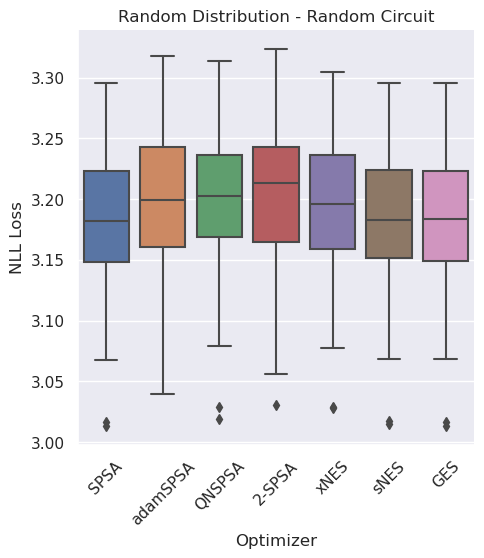

In [49]:
# Box / Violin Plots of converged results

# ----- Input Properties -----

# curr_data, title, y_label = ising_1d_runs, "1D Ising", "Energy"
# curr_data, title, y_label = random_ham_runs, "Randomized Hamiltonian", "Energy"
# curr_data, title, y_label = heisenburg_2d_runs, "2D Heisenburg", "Energy"
# curr_data, title, y_label = qcbm_gen_runs, "Cardinality Distribution - QCBM", "NLL Loss"
curr_data, title, y_label = rand_gen_runs, "Random Distribution - Random Circuit", "NLL Loss"

print(get_final_values(curr_data))

# ----------------------------

sns.set_theme()
# sns.set_context("paper")
x_label = 'Optimizer'

# sns.catplot(data=final_data, x="optimizer", y="loss", kind="boxen")
# sns.catplot(data=final_data, x="optimizer", y="loss", kind="violin")
# sns.catplot(data=final_data, x="optimizer", y="loss", kind="violin", inner="stick", bw=0.25, cut=0)

final_data = get_final_values(curr_data)
print(final_data.info())
ax = sns.catplot(data=final_data, x="optimizer", y="loss", kind="box", 
                 palette=optimizer_palette, order=optimizer_order)
ax.set(xlabel=x_label, ylabel=y_label, title=title)
ax.tick_params(axis='x', rotation=45)

AttributeError: module 'numpy' has no attribute 'randn'

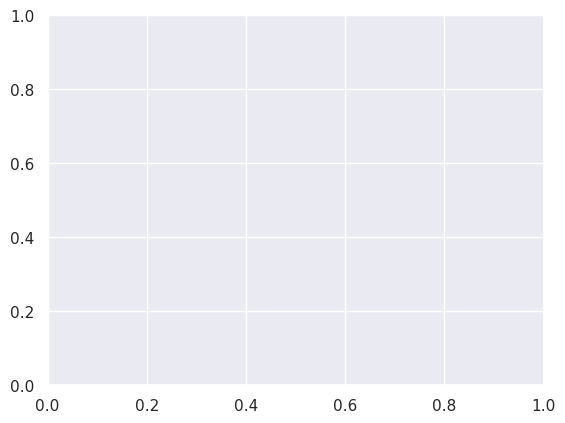

<Figure size 300x200 with 0 Axes>

In [64]:
# For producing horizontal legend of convergence plots

legendFig = plt.figure("Legend plot")
legendFig.legend([line1, line2], ["y=log(x)", "y=sin(x)"], loc='center')

In [22]:
# Other random testing / debugging

step_filter_freq = 3
x_lim = 2500
filter_inds = ((rand_gen_runs['step'] % step_filter_freq == 0) & (rand_gen_runs['step'] <= x_lim)) | (rand_gen_runs['step'] == x_lim-1)
# filter_inds = (rand_gen_runs['step'] % 5 == 0) | (rand_gen_runs['step'] == rand_gen_runs['step'].max())
print(filter_inds.iloc[:2500])
# curr_data = rand_gen_runs[filter_inds]
# print(curr_data)

# optimizer_order = ['SPSA','adamSPSA','QNSPSA','2-SPSA','xNES','sNES','GES']

# print(sns.color_palette().as_hex())

# optimizer_palette ={'SPSA':'#4c72b0',
#                     'adamSPSA':'#dd8452',
#                     'QNSPSA':'#55a868',
#                     '2-SPSA':'#c44e52',
#                     'xNES':'#8172b3',
#                     'sNES':'#937860',
#                     'GES':'#da8bc3',}

# print(random_ham_runs)

# # Apparently .history() method does adaptive sampling, so need scan_history() for everything?
# sweeps = ["3eopljqi"]
# filter_dict = {"sweep":{"$in":sweeps}}
# api = wandb.Api()
# entity, project = "ltecot", "quantum_optimization"
# runs = api.runs(entity + "/" + project, filters=filter_dict)
# summary_list, config_list, name_list = [], [], []
# runs_list = []
# for run in runs:
#     run_data = run.history(samples=5000)
#     print(run_data)
#     break

0        True
1       False
2       False
3        True
4       False
        ...  
2495    False
2496     True
2497    False
2498    False
2499     True
Name: step, Length: 2500, dtype: bool
